# 1. 인트로
## RNN과 LSTM, Attention

### <span style="background-color:#E1CBCB;"> RNN의 한계 = 장기의존성, 기울기 소실 </span> 

![img](https://cdn.analyticsvidhya.com/wp-content/uploads/2024/09/image-80.webp)
- RNN = 앞뒤 내용이 서로 연관된 데이터를 처리할 때 사용되는 모델로, 이전 단계의 정보를 '기억'하여 현재 내용 처리에 참고하는 구조를 가짐. 

- t-1 시험의 input이 t-1 시점의 output layer를 생성하면, t-1 시점의 hidden layer를 t 시점의 hidden으로 전달됨. 

- **가중치 공유**: 모든 time step에서 동일한 가중치를 반복해서 사용한다는 특징.
    - 파라미터 효율성
    - 학습 일반화 가능과 같은 장점이 있음. 

- **장기 의존성 문제**: 데이터의 후반부에서는 초반의 정보가 잘 반영되지 않음. 

<br>

![img](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2Fbc90rB%2Fbtrn4qBWaE9%2FAAAAAAAAAAAAAAAAAAAAAAf4BnF7qkBiSPhoh8zmmWuslwJpVBnwE3p9dn2WUcTJ%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1764514799%26allow_ip%3D%26allow_referer%3D%26signature%3DPL%252B7vn7ze2Igvoxc1cbyQNCWK68%253D)

\* 빨간색 화살표 부분이 역전파 과정! 

- **기울기 소실**: 
    - RNN에서 역전파로 파라미터를 업데이트를 시행할 때, 정보(시퀀스)가 길면 체인 룰을 시퀀스 길이만큼 여러 번 시행해야 함. 

    - BUT: 이 과정에서 1 미만의 값이 여러 번 곱해지게 되면 값이 0에 점점 가까워짐
        - ex) 0.7 * 0.7 * 0.7 * 0.7 * 0.7 * 0.7 * 0.7 = 0.08...

        - RNN은 tanh(범위가 -1 ~ +1 사이) 활성화 함수를 사용하여 기울기 소실이 일어날 가능성이 높음!

    - 역전파를 수행하더라도 **초기값에는 반영이 잘 되지 않음** (초기 정보가 학습(=파라미터 업데이트)과정에서 무시됨)

    - 즉, 반영되어야 하는 과거/초기의 정보가 일부 무시될 수 있음. 

### <span style="background-color:#E1CBCB;">LSTM의 한계 = 장기의존성 미해결</span>

- LSTM = 중요한 내용은 오래 기억하고, 필요 없는 정보는 잊어버리자
    - cell state = lstm 구조도에서 위쪽 화살표 = 가중치 곱셈하지 않고 직접적으로 전달되는 중요 정보
    - gate/hidden state = 아랫쪽 화살표 = 중요한 내용을 cell state로 보내고(input gate), 필요 없는 정보는 제거하고(forget gate), 필요한 정보만 뽑아냄(output gate)

- (장점) 오래 전에 입력된 정보는 그대로 오래 기억하고 (cell state), 덜 중요한 정보는 선별하여 기억할 수 있음

- (단점) 계산 시간이 오래 걸림 (게이트 연산)

- (단점) 여전히 긴 문장의 경우 기울기 소실 문제가 발생함
    - 초반부 데이터들이 forget gate를 통과해야 하는 횟수가 더 많기 때문
    
    - $f_t$ (활성화 함수 거친 값)이 계속 1이 되지 않는 이상 소숫점 곱셈 -> 언젠가는 작아짐

    - i.e. 0.95의 100승은 0.006... 

## Attention 의 등장
### Seq2Seq
- seq2seq = input 내용을 다른 시퀀스로 변환하는 구조
    - 기계 번역 등에 사용되는 구조

    - 입출력 개수가 동일하지 않아도 됨 / 형태, 내용 변환이 필요한 경우면 모두 적용 가능함

    - 인코더와 디코더 구조
        - 인코더: **이해** 담당, 중요한 내용을 context vector로 변환

        - 디코더: **생성** 담당, context vector를 이용해 결과를 출력 (번역문 등)

#### seq2seq의 **병목 현상**

<span style="background-color:#E1CBCB;">= 인코더가 input sequence의 정보를 압축하여 fixed size의 context vector 하나를 만들고, 디코더는 context vector만 참고하여 출력을 만드는 구조</span>

- **"고정된 사이즈의 context vector"?** : context vector는 인코더의 마지막 hidden state의 크기와 동일한 크기(size)를 가짐. **hidden size가 512라면 context vector도 512차원으로 고정**

- 문제는 짧은/긴 문장 상관없이 해당 사이즈(512 등)의 벡터에 의미를 모두 담아야 함
    - 짧은 문장의 경우 고정된 차원으로도 충분히 의미를 표현 가능

    - 긴 문장의 경우 내용이 과도하게 압축되며 정보 손실이 발생 (e.g. 나는 사과를 평소에 좋아하지 않지만 ... -> 나는 사과를 먹었다 (3단어/size로 표현하며 정보 손실))

### Attention
<span style="background-color:#E1CBCB;">= 중요한 것에 집중(attention) 하는 매커니즘.</span>

<span style="background-color:#E1CBCB;">= 결과 생성 시 입력값에서 (지금) 중요한 부분에 더 높은 가중치를 부여해서 참고하자</span>

- 출력 시점마다 새로운 context vector를 동적으로 계산하는 병렬화 기능을 가짐

#### 어텐션의 과정
- 입력을 벡터 형태로 수치화

- 각 요소 별 중요도 점수 산출 (score, sofrmax)

- 중요도에 따른 입력 정보 조합

#### 어텐션 매커니즘의 장점

- 시간 경과에 대해 유연하다
    RNN 계열은 장기 의존성 문제가 있는 반면, <br>
    attention은 먼 위치의 단어와 직접 연결하므로 단어 간 거리에 제약이 없다

- 공간에 대한 유연성
    CNN은 고정된 필터를 사용해 local 한 부분만 보게 되므로 공간적인 제약이 있다. <br>
    반면, 어텐션은 모든 픽셀이 다른 모든 픽셀과 연결 -> 전역적인 관계 학습이 가능하다. 

- 병렬화
    순차 계산(직렬적) 구조로 병렬/효율적인 처리가 불가능한 RNN계열과 달리, 어텐션은 모든 관계를 한번에, 독립적으로 계산한다. 

## Attention is All you need (Transformer, self-attention)

![img](https://img1.daumcdn.net/thumb/R1280x0.fpng/?fname=http://t1.daumcdn.net/brunch/service/user/f9wK/image/bpbwI9z5tr7PnKkm8K3NTXCSFCM.png)

<span style="background-color:#E1CBCB;">= self-attention 방식의 transformer 구조를 처음 소개한 google brain의 논문</span>

=> 해당 논문으로 attention 기반의 딥러닝 모델들이 self-attention을 채택하게 되는 계기가 됨

### 논문의 내용
- RNN 기반 모델의 한계, transformer의 등장

- transformer에서는 RNN의 순환 구조를 완전 제거, self-attention 구조를 제안

- 모델링에서 순환성이나 컨볼루션이 성능을 위한 필수 요소가 아님을 증명! 

- 모델 학습 속도 단축, 더 큰 모델 제작 가능

- 이로 인해 LLM이 탄생, NLP 평정, 여러 분야로의 확장이 일어남

### Transformer란?

아래 세 가지 요소가 트랜스포머의 핵심 기술!
- self attention
- multi-head attention
- positional encoding

# Self-Attention

## query, key, value

- query : 질문, 요청사항

- key: 정보들이 가지고 있는 이름표

- value: 키와 함께 묶여 있는 내용물(content)

- i.e. 유튜브 검색창의 요청값이 query, 검색 결과에 나오는 영상들의 제목이 key, 영상의 내용이 value

## cross-attention vs. self-attention

1. cross-attention: 기존의 어텐션 구조
    - RNN 계열 아키텍처 기반
    
    - 인코더 <-> 디코더의 서로 다른 시퀀스를 참조함 (번역할 문장을 슬쩍슬쩍 보며 단어 생성)

2. self-attention
    - 트랜스포머 아키텍처 기반

    - 동일한 시퀀스 내 참조 (문장 내부 <-> 문장 내부 뜯어보며 내부 관계 파악)

## Seq2Seq에서의 기존 attention
<span style="background-color:#E1CBCB;">= Q, K-V 쌍이 서로 다른 시퀀스에서 출력됨</span>

-> 디코더가 출력값을 만들 때, 입력의 어느 부분을 참고할지 결정함. 

## self-attention
<span style="background-color:#E1CBCB;">= Q와 K-V 쌍이 같은 시퀀스에서 출력된다</span>

”On Friday, the judge issued a sentence.” 에서 sentence에 대한 의미를 파악할 때, 

- sentence와 높은 관계에 있는 단어를 파악(계산)

- 관계를 기반으로 어떤 의미인지 파악

- judge, issued같은 단어에 높은 어텐션 가중치가 할당됨

- '문장'의 의미보다는 '선고'의 의미로 최종 해석

## Scaled Dot Product Attention

<span style="background-color:#E1CBCB;">= Attention Score를 계산하는 기본적인 방법. </span>

= Q *(내적) K 하여 유사도가 계산됨

- BUT: 벡터의 차원이 커질수록 내적의 결과도 너무 커지는/작아지는 문제가 발생

- vanishing gradient 문제와 유사함

### 해결 방법 = transformer 논문의 '스케일링'

<span style="background-color:#E1CBCB;">= 내적 후 값의 크기를 맞추는 스케일링을 진행</span>

![img](https://velog.velcdn.com/images%2Fcha-suyeon%2Fpost%2Fba830026-6d8f-4e77-b288-f75dd3a51457%2Fimage.png)

- $\sqrt{d_k}$ 라는 요소로 내적값을 나눔
    = key 벡터의 차원 수의 제곱근 값

- 최종적으로는 $\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$ 형식으로 내적을 계산

# Multi-Head Attention

![img](https://img1.daumcdn.net/thumb/R1280x0.fpng/?fname=http://t1.daumcdn.net/brunch/service/user/f9wK/image/Z5-nwAtSSSFtKe_UA5K56pQMHeQ.png)

multi-head attention은 인코더에서 한번, 디코더에서 두 번 사용된다. 

<span style="background-color:#E1CBCB;">= 인코딩된 토큰을 아키텍처가 이해할 때 사용되는 것</span>

## Why Multi-Head Attention?
- single head attention은 하나의 가중치 행렬만을 학습함 -> 단일 어텐션 구조에서 [문법, 의미관계, 위치관계 등] 모든 종류의 정보(관점)을 한번에 구해 **가중평균**을 구하므로 결과적으로는 중요한 관계를 놓칠 수 있음

- multi head attention: 단어-단어 간 관계를 여러 차원으로 나누어 병렬로 학습 = 여러 관점으로 나누어 보기!
    - 논문에서는 512차원의 input vector를 64 * 8 벡터로 나누어 병렬 계산함

## Multi-Head Attention 작동 방식
\* 64 * 8 벡터로 나누었을 때를 예시로 설명

- projection(투영): 8개의 헤드에 단어 벡터를 할당

- 병렬 어텐션 계산

- 결합(concat) 및 최종 투영

# Transformer 전체 아키텍처

## 전처리 단계

### 토큰화

<span style="background-color:#E1CBCB;">= 모델이 처리할 수 있는 단위/token으로 나누는 것</span>

### 임베딩

<span style="background-color:#E1CBCB;">= 정보를 숫자 벡터로 변환하는 것</span>

### 포지셔널 인코딩

<span style="background-color:#E1CBCB;">= 문맥 파악을 위해서는 위치 정보의 손실이 있으면 안됨! 일관된 순서를 따르는 숫자를 추가하는 과정</span>

$PE_{(pos, 2i)} = \sin(\frac{pos}{10000^{2i/d_{model}}})$

$PE_{(pos, 2i+1)} = \cos(\frac{pos}{10000^{2i/d_{model}}})$

-> 위치에 따라 고유한 PE 값을 사용함

## 트랜스포머의 인코더와 디코더

### 1. 인코더

<span style="background-color:#E1CBCB;">= 입력 문장을 이해, 의미 벡터로 변환하는 역할 수행</span>

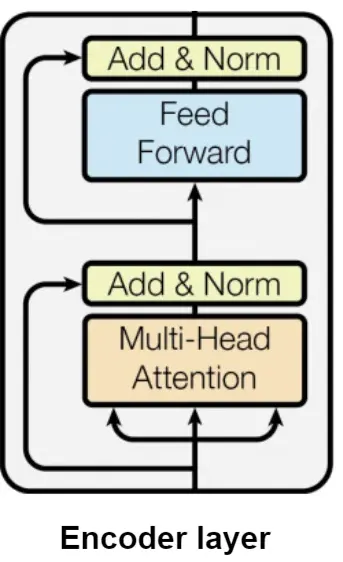

-> multi-head attention과 feed forward로 구성됨

\* feed forward(FFN) : 입력 벡터의 차원을 확장하고 비선형 변환을 적용하여 새로운 representation을 생성하는 신경망 구조
= MLP가 2층 완전 연결된 구조

<span style="background-color:#E1CBCB;">= multi-head attention에서 집중에서 봐야 한다고 정해 둔 단어를 FFN에서 전문 분석단이 심층 분석하는 것</span>

\* Add & Norm : 입력값을 출력에 더해 주는 것. 

### 2. 디코더
<span style="background-color:#E1CBCB;">= 인코더가 넘겨준 의미 벡터를 받아 **출력 문장을 순차적으로 생성**하는 역할 수행</span>

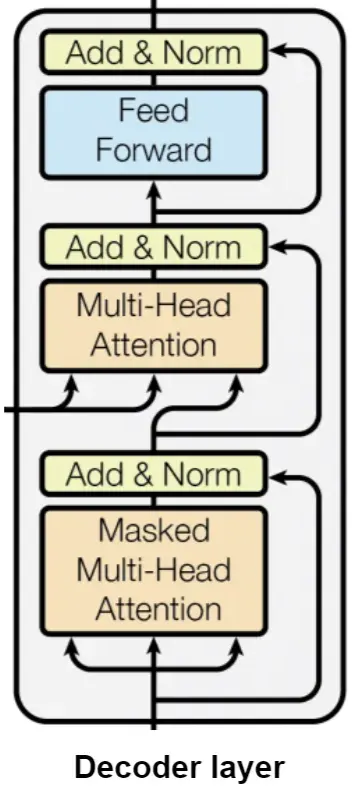

-> **Masked Multi-Head Attention**, **Encoder-Decoder** Multi-Head **Attention (Cross-Attention)**, Feed-Forward Layer 로 구성

\* masked multi head attention: 미래 시점의 단어 정보를 보지 못하도록 mask를 적용하는 매커니즘
    시퀀스를 좌-우로 생성하므로 미래 값은 0으로 만들어 무시
-> 정답을 미리 보게 되어 정확도가 떨어지게 되는 문제를 해결함!

## 전체 모델 및 데이터 흐름

- 입력 준비 : 번역할 문장을 의미 + 위치벡터로 바꾸기

- 인코더: 입력 문장의 의미 이해

- 디코더 : 번역 문장을 순차적으로 생성